In [1]:
%matplotlib inline


In [2]:
HELPid="HELP_J100232.92+020027.45"


In [3]:
import argparse
from itertools import product, repeat
from collections import OrderedDict
import sys

from astropy.table import Table

import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import pkg_resources
from pcigale.data import Database
from scipy.constants import c
from scipy import stats
from pcigale.utils import read_table
import matplotlib.gridspec as gridspec
from scipy.stats import chisquare
from math import log10

# Name of the file containing the best models information
BEST_RESULTS = "results.fits"
# Wavelength limits (restframe) when plotting the best SED.
PLOT_L_MIN = 0.1
PLOT_L_MAX = 5e5

 HELP_J100232.92+020027.45 at z = 0.58


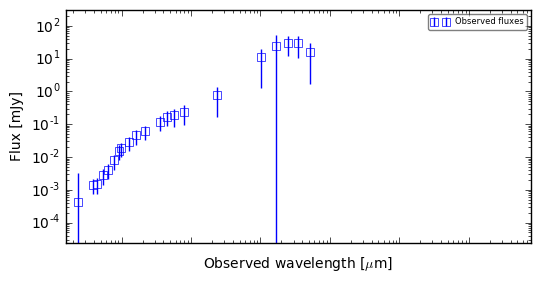

In [4]:
sed = Table.read("{}_best_model.fits".format(HELPid))
obs = Table.read("part_0.fits")
mod=Table.read(BEST_RESULTS)

wavelength_spec = sed['wavelength']
z = obs[obs['id'] == HELPid]['redshift'][0]
DL = mod[obs['id'] == HELPid]['best.universe.luminosity_distance'][0]


obs_fluxes, obs_fluxes_err,filters_wl,mask_ok,mod_fluxes=[],[],[],[],[]
del obs_fluxes[:]
del obs_fluxes_err[:]
del filters_wl[:]
del mask_ok[:]
del mod_fluxes[:]

filters = [item for item in obs.colnames if item not in ('id', 'redshift') and not item.endswith('_err')]
filters_err = [item for item in obs.colnames if item not in ('id', 'redshift') and item.endswith('_err')]

for filt in filters:
    obs_fluxes.append(obs[obs['id'] == HELPid][filt][0])
obs_fluxes=np.array(obs_fluxes)

for filt in filters_err:
    obs_fluxes_err.append(obs[obs['id'] == HELPid][filt][0])

for filt in filters:
    mod_fluxes.append(mod[mod['id'] == HELPid]["best."+filt][0])

with Database() as db:
    for name in filters:
        tmp = db.get_filter(name)
        filters_wl.append(tmp.effective_wavelength/1000.0)

xmin = PLOT_L_MIN * (1. + z)
xmax = PLOT_L_MAX * (1. + z)

k_corr_SED = 1.    

for cname in sed.colnames[1:]:
    sed[cname] *= (wavelength_spec * 1e29 /  (c / (wavelength_spec * 1e-9)) / (4. * np.pi * DL * DL))

wavelength_spec /= 1000.

wsed = np.where((wavelength_spec > xmin) & (wavelength_spec < xmax))

obs_fluxes=np.array(obs_fluxes)
obs_fluxes_err=np.array(obs_fluxes_err)
filters=np.array(filters)
filters_wl=np.array(filters_wl)
mod_fluxes=np.array(mod_fluxes)

plt.close('all')

figure = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
if (sed.columns[1][wsed] > 0.).any():
    ax1 = plt.subplot(gs[0])
    ax1.loglog(wavelength_spec[wsed], sed['L_lambda_total'][wsed],
                       label="", color='white', nonposy='clip',
                       linestyle='-', linewidth=0)
     
    mask_ok = np.logical_and(obs_fluxes > 0., obs_fluxes_err > 0.)

    ax1.errorbar(filters_wl[mask_ok], obs_fluxes[mask_ok],
                         yerr=obs_fluxes_err[mask_ok]*3, ls='', marker='s',
                         label='Observed fluxes', markerfacecolor='None',
                         markersize=6, markeredgecolor='b', capsize=0.)

    mask = np.where(obs_fluxes > 0.)
 
    figure.subplots_adjust(hspace=0., wspace=0.)

    ax1.set_xlim(xmin, xmax)
    ymin = min(np.min(obs_fluxes[mask_ok]),
                       np.min(mod_fluxes[mask_ok]))
    ymax = max(np.max(obs_fluxes[mask_ok]),
                           np.max(mod_fluxes[mask_ok]))
    ax1.set_ylim(1e-1*ymin, 1e1*ymax)

    ax1.set_xlabel("Observed wavelength [$\mu$m]")
    ax1.set_ylabel("Flux [mJy]")
    ax1.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels()[1], visible=False)
    
    print(" {} at z = {:.2f}". format(HELPid, z))
   



####################################################################################################################

### MAIN BEST RESULTS FOR STELLAR PART OF THE SPECTRA AND ATTENUATION:

In [5]:
print("stellar mass: {:.2f} [stellar mass]".format(log10(mod[obs['id'] == HELPid]['best.stellar.m_star'][0])))
print("V-band attenuation in the birth clouds: {:.2f} ".format((mod[obs['id'] == HELPid]['best.attenuation.Av_BC'][0])))
print("attenuation in FUV band: {:.2f} [mag]".format((mod[obs['id'] == HELPid]['best.attenuation.FUV'][0])))
print("attenuation in V band: {:.2f} [mag]".format((mod[obs['id'] == HELPid]['best.attenuation.V_B90'][0])))


stellar mass: 10.73 [stellar mass]
V-band attenuation in the birth clouds: 3.30 
attenuation in FUV band: 4.50 [mag]
attenuation in V band: 1.55 [mag]


#### Below on the plot stellar components (attenuated and unattenuated) are plotted against observed fluxes:

NameError: name 'ax2' is not defined

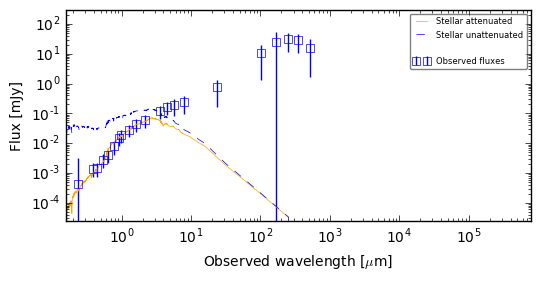

In [6]:
if (sed.columns[1][wsed] > 0.).any():
    ax1 = plt.subplot(gs[0])
    ax1.loglog(wavelength_spec[wsed], (sed['stellar.young'][wsed] + sed['attenuation.stellar.young'][wsed] + 
               sed['stellar.old'][wsed] + sed['attenuation.stellar.old'][wsed]), 
               label="Stellar attenuated ", color='orange', marker=None, nonposy='clip', linestyle='-', linewidth=0.5)
    ax1.loglog(wavelength_spec[wsed], (sed['stellar.old'][wsed] +  sed['stellar.young'][wsed]), 
               label="Stellar unattenuated", color='b', marker=None, nonposy='clip', linestyle='--', linewidth=0.5)
    ax1.loglog(wavelength_spec[wsed], sed['L_lambda_total'][wsed], label=" ", color='white', nonposy='clip', 
               linestyle='-', linewidth=0)

    ax1.set_autoscale_on(False)
    mask_ok = np.logical_and(obs_fluxes > 0., obs_fluxes_err > 0.)
    ax1.errorbar(filters_wl[mask_ok], obs_fluxes[mask_ok], yerr=obs_fluxes_err[mask_ok]*3, ls='', marker='s', 
                 label='Observed fluxes', markerfacecolor='None',markersize=6, markeredgecolor='b', capsize=0.)

    mask = np.where(obs_fluxes > 0.)

    figure.subplots_adjust(hspace=0., wspace=0.)

    ax1.set_xlim(xmin, xmax)
    ymin = min(np.min(obs_fluxes[mask_ok]), np.min(mod_fluxes[mask_ok]))
    ymax = max(np.max(obs_fluxes[mask_ok]), np.max(mod_fluxes[mask_ok]))
    ax1.set_ylim(1e-1*ymin, 1e1*ymax)

    ax1.set_xlabel("Observed wavelength [$\mu$m]")
    ax1.set_ylabel("Flux [mJy]")
    ax1.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    ax2.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels()[1], visible=False)
    print("Best model for {} at z = {:.2f}. best log(Mstar) = {:.2f}". format(HELPid, z,log10(mod[obs['id'] == HELPid]['best.stellar.m_star'][0])))
    

### MAIN BEST RESULTS FOR DUST EMISSION:

In [ ]:
print("power law slope dU/dM (alpha) : {:.2f}".format((mod[obs['id'] == HELPid]['best.dust.alpha'][0])))
print("fraction illuminated from Umin to Umax (gamma): {:.2f} ".format((mod[obs['id'] == HELPid]['best.dust.gamma'][0])))
print("mass fraction of PAH: {:.2f} ".format((mod[obs['id'] == HELPid]['best.dust.qpah'][0])))
print("minimum radiation field: {:.2f} ".format((mod[obs['id'] == HELPid]['best.dust.umin'][0])))
print("best dust luminosity: {:.2f} [stellar luminosity]".format(log10((mod[obs['id'] == HELPid]['best.dust.luminosity'][0])/(3.846*pow(10,26)))))

#### Below on the plot dust component is  plotted against observed fluxes:

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Best model for HELP_J100232.92+020027.45 at z = 0.58. best log(Ldust) = 11.21


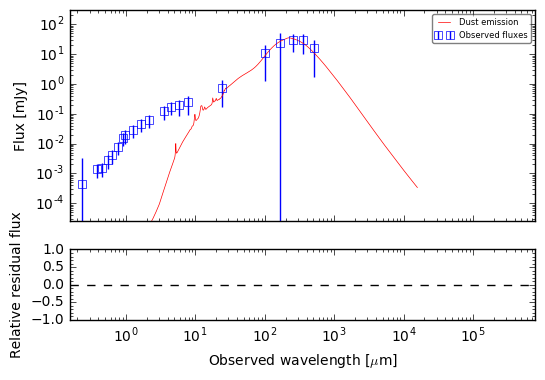

In [7]:
if (sed.columns[1][wsed] > 0.).any():
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax1.loglog(wavelength_spec[wsed],
                           (sed['dust.Umin_Umin'][wsed] +
                            sed['dust.Umin_Umax'][wsed]),
                           label="Dust emission", color='r', marker=None,
                           nonposy='clip', linestyle='-', linewidth=0.5)
    ax1.loglog(wavelength_spec[wsed], sed['L_lambda_total'][wsed],
                       label="", color='white', nonposy='clip',
                       linestyle='-', linewidth=0)

    mask_ok = np.logical_and(obs_fluxes > 0., obs_fluxes_err > 0.)
    ax1.errorbar(filters_wl[mask_ok], obs_fluxes[mask_ok],
                         yerr=obs_fluxes_err[mask_ok]*3, ls='', marker='s',
                         label='Observed fluxes', markerfacecolor='None',
                         markersize=6, markeredgecolor='b', capsize=0.)

    mask = np.where(obs_fluxes > 0.)
    ax2.plot([xmin, xmax], [0., 0.], ls='--', color='k')
    ax2.set_xscale('log')
    ax2.minorticks_on()

    figure.subplots_adjust(hspace=0., wspace=0.)

    ax1.set_xlim(xmin, xmax)
    ymin = min(np.min(obs_fluxes[mask_ok]),
                       np.min(mod_fluxes[mask_ok]))
    ymax = max(np.max(obs_fluxes[mask_ok]),
                           np.max(mod_fluxes[mask_ok]))
    ax1.set_ylim(1e-1*ymin, 1e1*ymax)
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(-1.0, 1.0)

    ax2.set_xlabel("Observed wavelength [$\mu$m]")
    ax1.set_ylabel("Flux [mJy]")
    ax2.set_ylabel("Relative residual flux")
    ax1.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    ax2.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels()[1], visible=False)
print("Best model for {} at z = {:.2f}. best log(Ldust) = {:.2f}". format(HELPid, z,log10((mod[obs['id'] == HELPid]['best.dust.luminosity'][0])/(3.846*pow(10,26)))))

### MAIN BEST RESULTS FOR AGN component:

In [ ]:
print("best fraction of AGN : {:.2f}".format((mod[obs['id'] == HELPid]['best.agn.fracAGN'][0])))
if mod[obs['id'] == HELPid]['best.agn.fracAGN'][0]>0:
    print("best AGN liminosity: {:.2f} [stellar luminosity]".format(log10((mod[obs['id'] == HELPid]['best.agn.luminosity'][0])/(3.846*pow(10,26)))))




Best model for HELP_J100232.92+020027.45 at z = 0.58. best AGNfrac) = 0.25


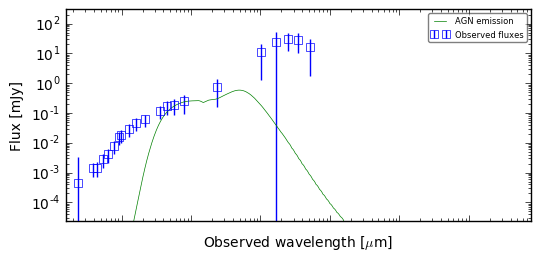

In [8]:
if mod[obs['id'] == HELPid]['best.agn.fracAGN'][0]>0:

    if (sed.columns[1][wsed] > 0.).any():
        ax1 = plt.subplot(gs[0])
        ax1.loglog(wavelength_spec[wsed],(sed['agn.fritz2006_therm'][wsed] + sed['agn.fritz2006_scatt'][wsed] + 
                    sed['agn.fritz2006_agn'][wsed]),label="AGN emission", color='g', marker=None, nonposy='clip', linestyle='-', linewidth=0.5)
        ax1.loglog(wavelength_spec[wsed], sed['L_lambda_total'][wsed], label="", color='white', nonposy='clip',
                       linestyle='-', linewidth=0)

        mask_ok = np.logical_and(obs_fluxes > 0., obs_fluxes_err > 0.)
        ax1.errorbar(filters_wl[mask_ok], obs_fluxes[mask_ok], yerr=obs_fluxes_err[mask_ok]*3, ls='', marker='s',
                label='Observed fluxes', markerfacecolor='None',markersize=6, markeredgecolor='b', capsize=0.)

        mask = np.where(obs_fluxes > 0.)

        figure.subplots_adjust(hspace=0., wspace=0.)

        ax1.set_xlim(xmin, xmax)
        ymin = min(np.min(obs_fluxes[mask_ok]), np.min(mod_fluxes[mask_ok]))
        ymax = max(np.max(obs_fluxes[mask_ok]), np.max(mod_fluxes[mask_ok]))
        ax1.set_ylim(1e-1*ymin, 1e1*ymax)

        ax1.set_xlabel("Observed wavelength [$\mu$m]")
        ax1.set_ylabel("Flux [mJy]")
        ax1.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.setp(ax1.get_yticklabels()[1], visible=False)

    print("Best model for {} at z = {:.2f}. best AGNfrac) = {:.2f}". format(HELPid, z,(mod[obs['id'] == HELPid]['best.agn.fracAGN'][0])))    

### In the last step all modules are merge together to computed one best model (based on the $\chi^2$) marked as a black line in the figure below. 

Modeled fluxes for each filter used for SED fitting are calculated based on the best model. The relative residual fluxes are ploted in the bottom panel of the figure. 

Final $\chi^2$ value as well as main physical parameters computed based on PDF analysis are listed below:


In [ ]:
print("reduced $\chi^2$ : {:.2f} ".format((mod[obs['id'] == HELPid]['best.reduced_chi_square'][0])))
print("bayesian stellar mass {:.2f} +/- {:.2f} [M sun]:".format(log10(mod[obs['id'] == HELPid]['bayes.stellar.m_star'][0]),0.434*(mod[obs['id'] == HELPid]['bayes.stellar.m_star'][0])/(mod[obs['id'] == HELPid]['bayes.stellar.m_star_err'][0])))
print("bayesian dust luminosity: {:.2f} +/- {:.2f} [L sun]".format(log10((mod[obs['id'] == HELPid]['bayes.dust.luminosity'][0])/(3.846*pow(10,26))),0.434*(mod[obs['id'] == HELPid]['bayes.dust.luminosity'][0])/(mod[obs['id'] == HELPid]['bayes.dust.luminosity_err'][0])))
print("bayesian SFR {:.2f} +/- {:.2f} [M sun / yr]:".format((mod[obs['id'] == HELPid]['bayes.sfh.sfr10Myrs'][0]),(mod[obs['id'] == HELPid]['bayes.sfh.sfr10Myrs_err'][0])))
print("bayesian AGN fraction {:.2f} +/- {:.2f}:".format((mod[obs['id'] == HELPid]['bayes.agn.fracAGN'][0]),(mod[obs['id'] == HELPid]['bayes.agn.fracAGN_err'][0])))

Best model for HELP_J100232.92+020027.45 at z = 0.58, best(Mstar) = 10.73, best log(Ldust) = 11.21, best AGNfrac = 0.25


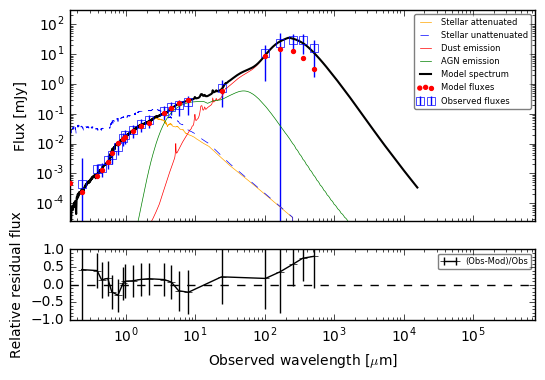

In [9]:
if (sed.columns[1][wsed] > 0.).any():
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    # Stellar emission
    ax1.loglog(wavelength_spec[wsed], (sed['stellar.young'][wsed] + sed['attenuation.stellar.young'][wsed] + 
               sed['stellar.old'][wsed] + sed['attenuation.stellar.old'][wsed]), label="Stellar attenuated ", 
               color='orange', marker=None, nonposy='clip', linestyle='-',linewidth=0.5)
    ax1.loglog(wavelength_spec[wsed],(sed['stellar.old'][wsed] + sed['stellar.young'][wsed]), 
               label="Stellar unattenuated", color='b', marker=None,nonposy='clip', linestyle='--', linewidth=0.5)
    #Dust emission
    ax1.loglog(wavelength_spec[wsed], (sed['dust.Umin_Umin'][wsed] + sed['dust.Umin_Umax'][wsed]), 
               label="Dust emission", color='r', marker=None, nonposy='clip', linestyle='-', linewidth=0.5)
    # AGN emission Fritz
    if 'agn.fritz2006_therm' in sed.columns:
        ax1.loglog(wavelength_spec[wsed], (sed['agn.fritz2006_therm'][wsed] + sed['agn.fritz2006_scatt'][wsed] + 
                sed['agn.fritz2006_agn'][wsed]), label="AGN emission", color='g', marker=None, nonposy='clip', 
                   linestyle='-', linewidth=0.5)

    ax1.loglog(wavelength_spec[wsed], sed['L_lambda_total'][wsed], label="Model spectrum", color='k', nonposy='clip',
                       linestyle='-', linewidth=1.5)

    ax1.set_autoscale_on(False)
    ax1.scatter(filters_wl, mod_fluxes, marker='o', color='r', s=8,zorder=3, label="Model fluxes")
    mask_ok = np.logical_and(obs_fluxes > 0., obs_fluxes_err > 0.)
    ax1.errorbar(filters_wl[mask_ok], obs_fluxes[mask_ok], yerr=obs_fluxes_err[mask_ok]*3, ls='', marker='s', 
                 label='Observed fluxes', markerfacecolor='None', markersize=6, markeredgecolor='b', capsize=0.)

    mask = np.where(obs_fluxes > 0.)
    ax2.errorbar(filters_wl[mask],(obs_fluxes[mask]-mod_fluxes[mask])/obs_fluxes[mask],  
                 yerr=obs_fluxes_err[mask]/obs_fluxes[mask]*3, marker='_', label="(Obs-Mod)/Obs", color='k', capsize=0.)
    ax2.plot([xmin, xmax], [0., 0.], ls='--', color='k')
    ax2.set_xscale('log')
    ax2.minorticks_on()

    figure.subplots_adjust(hspace=0., wspace=0.)

    ax1.set_xlim(xmin, xmax)
    ymin = min(np.min(obs_fluxes[mask_ok]),np.min(mod_fluxes[mask_ok]))
    ymax = max(np.max(obs_fluxes[mask_ok]),np.max(mod_fluxes[mask_ok]))
    ax1.set_ylim(1e-1*ymin, 1e1*ymax)
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(-1.0, 1.0)

    ax2.set_xlabel("Observed wavelength [$\mu$m]")
    ax1.set_ylabel("Flux [mJy]")
    ax2.set_ylabel("Relative residual flux")
    ax1.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    ax2.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels()[1], visible=False)
    
    print("Best model for {} at z = {:.2f}, best(Mstar) = {:.2f}, best log(Ldust) = {:.2f}, best AGNfrac = {:.2f}". 
          format(HELPid, z,log10(mod[obs['id'] == HELPid]['best.stellar.m_star'][0]),
                 log10((mod[obs['id'] == HELPid]['best.dust.luminosity'][0])/(3.846*pow(10,26))), 
                 mod[obs['id'] == HELPid]['best.agn.fracAGN'][0]))    

# Global redshift vs stellar mass, redshift vs dust luminosity and redshift vs SFR relations:

### In three figures below red star corresponds to the analized galaxy: 

## redshift vs stellar mass

In [ ]:

mstar,red,ldust,sfr=[],[],[],[]
for gal in range(0,len(mod)):
    if mod[gal]['best.reduced_chi_square']<4:
        mstar.append(log10(mod[gal]['bayes.stellar.m_star']))
        red.append((mod[gal]['redshift']))
        ldust.append(log10(mod[gal]['bayes.dust.luminosity']/(3.846*pow(10,26))))
        sfr.append(log10(mod[gal]['bayes.sfh.sfr10Myrs']))

mstar=np.array(mstar)
red=np.array(red)
ldust=np.array(ldust)
sfr=np.array(sfr)

ax1 = plt.subplot(gs[0])

ax1.plot(red, mstar,'-o',c='lightgray',linewidth=0,linestyle=' ')
specific_mstar=log10(mod[obs['id'] == HELPid]['bayes.stellar.m_star'][0])
ax1.plot(z,specific_mstar,'-*',c='red',markersize=15)

ax1.set_xlabel("redshift")
ax1.set_ylabel("log(Mstar)")
ax1.set_ylim(7, 12)

ax1.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5) 

## redshift vs dust luminosity

In [ ]:
ax1 = plt.subplot(gs[0])

ax1.plot(red, ldust,'-o',c='lightgray',linewidth=0,linestyle=' ')
specific_Ldust=log10(mod[obs['id'] == HELPid]['bayes.dust.luminosity']/(3.846*pow(10,26)))
ax1.plot(z,specific_Ldust,'-*',c='red',markersize=15)

ax1.set_xlabel("redshift")
ax1.set_ylabel("log(Ldust)")
ax1.set_ylim(8, 14)

ax1.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5) 

## redshift vs SFR

In [ ]:
ax1 = plt.subplot(gs[0])

ax1.plot(red, sfr,'-o',c='lightgray',linewidth=0,linestyle=' ')
specific_sfr=log10(mod[obs['id'] == HELPid]['bayes.sfh.sfr10Myrs'])
ax1.plot(z,specific_sfr,'-*',c='red',markersize=15)

ax1.set_xlabel("redshift")
ax1.set_ylabel("log(SFR)")
ax1.set_ylim(-2, 4)

ax1.legend(fontsize=6, loc='best', fancybox=True, framealpha=0.5) 